In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
df = pd.read_csv('../Data/hysteresis/attachments/hys_kjh.csv')

In [3]:
df.head(3)

,Unnamed: 0,e,f
0,1,0.000000,0.000000
1,2,0.000000,0.015758
2,3,0.000234,0.030466


<AxesSubplot: >

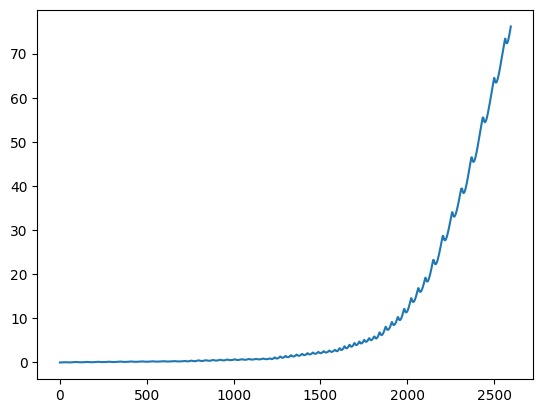

In [4]:
df.e.plot()

<AxesSubplot: >

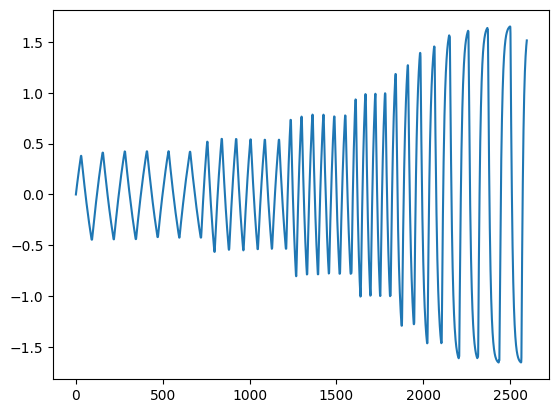

In [5]:
df.f.plot()

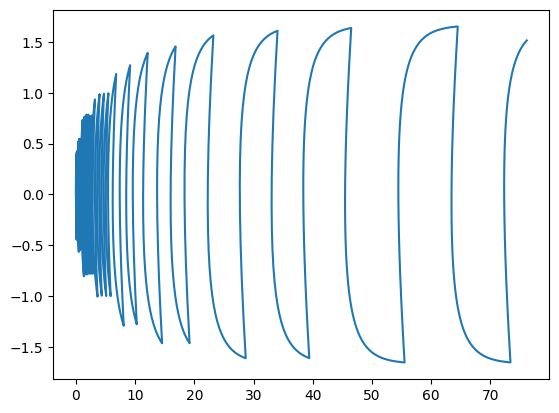

In [6]:
plt.plot(df.iloc[:,1], df.iloc[:,2])

In [7]:
df = df.iloc[:,1:]

<AxesSubplot: >

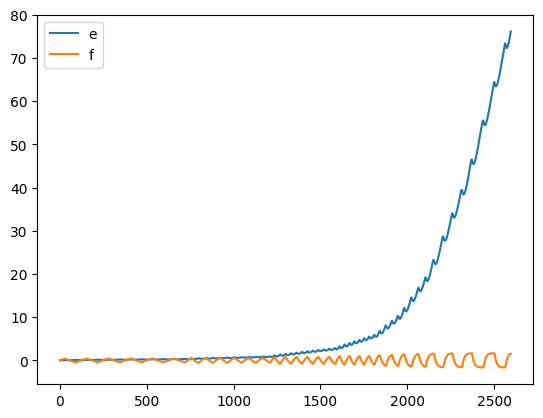

In [8]:
df.plot()

In [9]:
#hysteresis curve equation
def hys_curve(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f


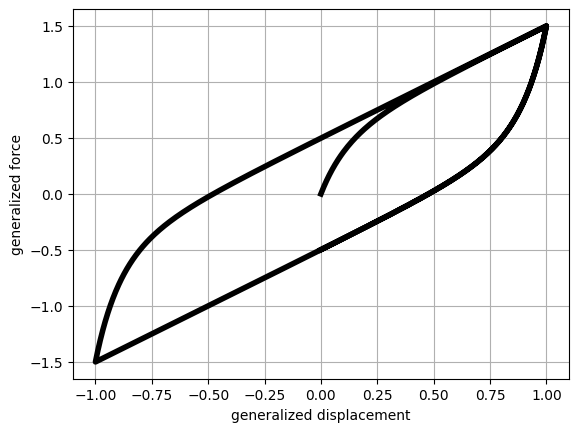

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# APPLIED DISPLACEMENT TIME HISTORY
dt = 0.001
t = np.arange(0, 1.5 + dt, dt)
a0 = 1
fr = 1
u = a0 * np.sin(2 * np.pi * fr * t[:len(t)])
v = 2 * np.pi * fr * a0 * np.cos(2 * np.pi * fr * t[:len(t)])
n = len(u)

# 1. INITIAL SETTINGS
# 1.1 Set the five model parameters
ka = 10.0
kb = 1.0
alfa = 10.0
beta1 = 0.0
beta2 = 0.0

# 1.2 Compute the internal model parameters
u0 = 0.5 * (((ka - kb) / 1e-20) ** (1 / alfa) - 1)
f0 = ((ka - kb) / 2) * (((1 + 2 * u0) ** (1 - alfa) - 1) / (1 - alfa))

# 1.3 Initialize the generalized force vector
f = np.zeros(n)

# 2. CALCULATIONS AT EACH TIME STEP
for i in range(1, n):
    # 2.1 Update the history variable
    uj = u[i - 1] + np.sign(v[i]) * (1 + 2 * u0) - np.sign(v[i]) * (((np.sign(v[i]) * (1 - alfa)) / (ka - kb)) * (f[i - 1] - beta1 * u[i - 1] ** 3 - beta2 * u[i - 1] ** 5 - kb * u[i - 1] - np.sign(v[i]) * f0 + (ka - kb) * (((1 + 2 * u0) ** (1 - alfa)) / (np.sign(v[i]) * (1 - alfa))))) ** (1 / (1 - alfa))

    # 2.2 Evaluate the generalized force at time t
    if (np.sign(v[i]) * uj) - 2 * u0 < np.sign(v[i]) * u[i] or np.sign(v[i]) * u[i] < np.sign(v[i]) * uj:
        f[i] = beta1 * u[i] ** 3 + beta2 * u[i] ** 5 + kb * u[i] + (ka - kb) * ((((1 + 2 * u0 + np.sign(v[i]) * (u[i] - uj)) ** (1 - alfa)) / (np.sign(v[i]) * (1 - alfa))) - (((1 + 2 * u0) ** (1 - alfa)) / (np.sign(v[i]) * (1 - alfa)))) + np.sign(v[i]) * f0
    else:
        f[i] = beta1 * u[i] ** 3 + beta2 * u[i] ** 5 + kb * u[i] + np.sign(v[i]) * f0

# PLOT
plt.figure()
plt.plot(u, f, 'k', linewidth=4)
plt.xlabel('generalized displacement')
plt.ylabel('generalized force')
plt.grid()
plt.show()


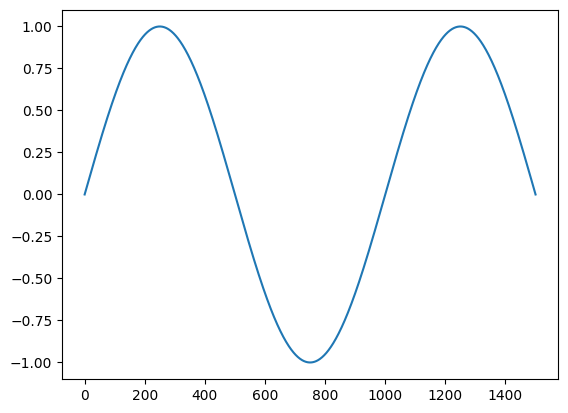

In [11]:
plt.plot(u)

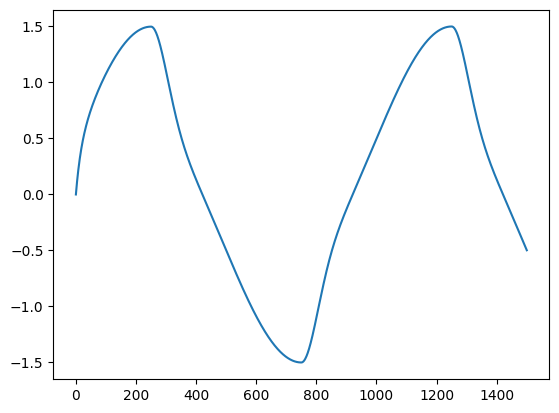

In [12]:
plt.plot(f)

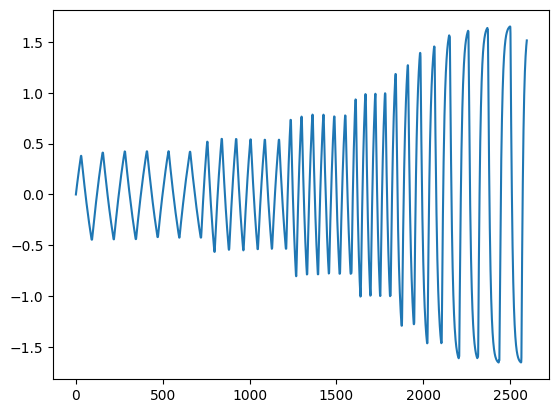

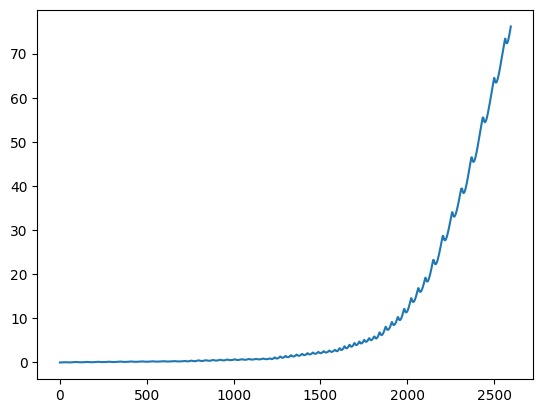

In [13]:
plt.plot(df.iloc[:,1])
plt.show()
plt.plot(df.iloc[:,0])
plt.show()

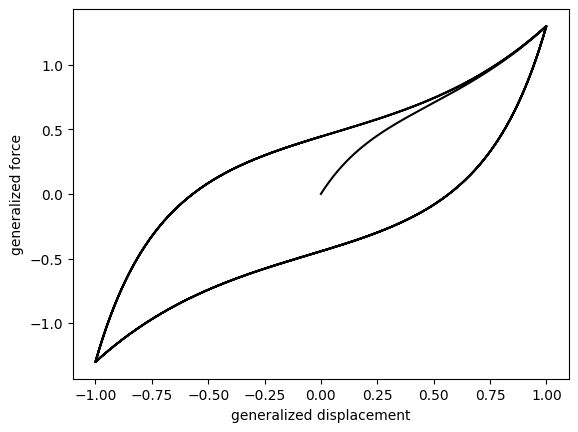

In [213]:
# APPLIED DISPLACEMENT TIME HISTORY
dt = 0.001
t = np.arange(0, 3 + dt, dt)
a0 = 1
fr = 1
u = a0 * np.sin(2 * np.pi * fr * t[:len(t)])
v = 2 * np.pi * fr * a0 * np.cos(2 * np.pi * fr * t[:len(t)])
n = len(u)

# INITIAL SETTINGS
# Set the four model parameters
ka = 5.0
kb = 0.5
alfa = 5.0
beta = 1.0
# Compute the internal model parameters
u0 = -(1 / (2 * alfa)) * np.log(10 ** -20 / (ka - kb))
f0 = ((ka - kb) / (2 * alfa)) * (1 - np.exp(-2 * alfa * u0))
# Initialize the generalized force vector
f = np.zeros(n)

# CALCULATIONS AT EACH TIME STEP
for i in range(1, n):
    # Update the history variable
    uj = u[i-1] + 2*u0*np.sign(v[i]) + np.sign(v[i])*(1/alfa)*np.log(np.abs(np.sign(v[i])*(alfa/(ka-kb))*(-2*beta*u[i-1]+np.exp(beta*u[i-1])-np.exp(-beta*u[i-1])+kb*u[i-1]+np.sign(v[i])*((ka-kb)/alfa)*np.exp(-2*alfa*u0)+np.sign(v[i])*f0-f[i-1])))
    # Evaluate the generalized force at time t
    if (np.sign(v[i])*uj-2*u0 < np.sign(v[i])*u[i]) or (np.sign(v[i])*u[i] < np.sign(v[i])*uj):
        f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(u[i]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0
    else:
        f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] + np.sign(v[i])*f0

# PLOT
plt.figure()
plt.plot(u, f, 'k')
plt.xlabel('generalized displacement')
plt.ylabel('generalized force')
plt.show()


In [92]:
from sklearn.preprocessing import StandardScaler

In [93]:
sc = StandardScaler()

In [16]:
import keras
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM

In [216]:
x_tr = tf.convert_to_tensor(u[:2000])
y_tr = tf.convert_to_tensor(f[:2000])

x_te = tf.convert_to_tensor(u[2000:])
y_te = f[2000:]

In [217]:
x_tr = tf.reshape(x_tr, (-1, 1, 1))
y_tr = tf.reshape(y_tr, (-1, 1, 1))

x_te = tf.reshape(x_te, (-1, 1, 1))

In [218]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(100, input_shape=(1, 1), return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense(1))

In [219]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1, 100)            40800     
                                                                 
 dropout_16 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dense_94 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [220]:
model.compile(loss = 'mse', optimizer = 'adam')

In [221]:
history = model.fit(x_tr, y_tr, epochs = 500)

Epoch 1/500
63/63 [==============================] - 8s 4ms/step - loss: 0.4067
Epoch 2/500
63/63 [==============================] - 0s 5ms/step - loss: 0.1299
Epoch 3/500
63/63 [==============================] - 0s 5ms/step - loss: 0.1291
Epoch 4/500
63/63 [==============================] - 0s 5ms/step - loss: 0.1283
Epoch 5/500
63/63 [==============================] - 0s 5ms/step - loss: 0.1292
Epoch 6/500
63/63 [==============================] - 0s 5ms/step - loss: 0.1277
Epoch 7/500
63/63 [==============================] - 0s 5ms/step - loss: 0.1287
Epoch 8/500
63/63 [==============================] - 0s 5ms/step - loss: 0.1276
Epoch 9/500
63/63 [==============================] - 0s 6ms/step - loss: 0.1282
Epoch 10/500
63/63 [==============================] - 0s 6ms/step - loss: 0.1276
Epoch 11/500
63/63 [==============================] - 0s 6ms/step - loss: 0.1279
Epoch 12/500
63/63 [==============================] - 0s 6ms/step - loss: 0.1277
Epoch 13/500
63/63 [=================

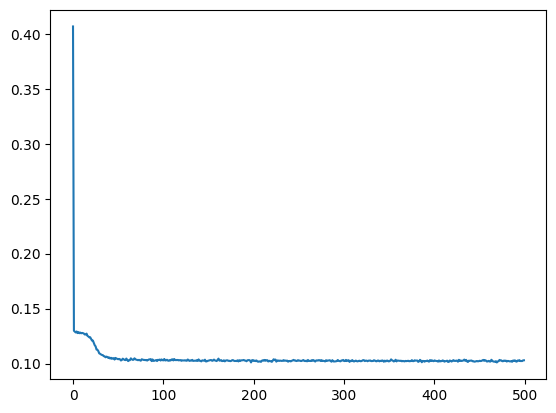

In [222]:
plt.plot(history.history['loss'])

In [223]:
pred = model.predict(x_te)

32/32 [==============================] - 2s 3ms/step


In [224]:
pred = pred.reshape(-1,1)

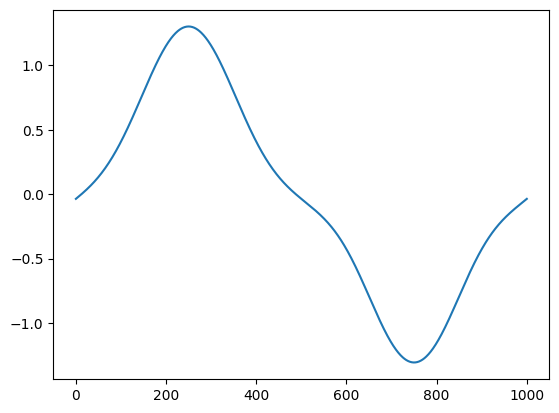

In [225]:
plt.plot(pred)

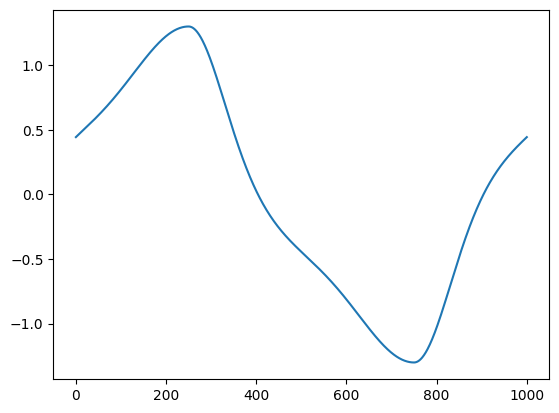

In [226]:
plt.plot(y_te)

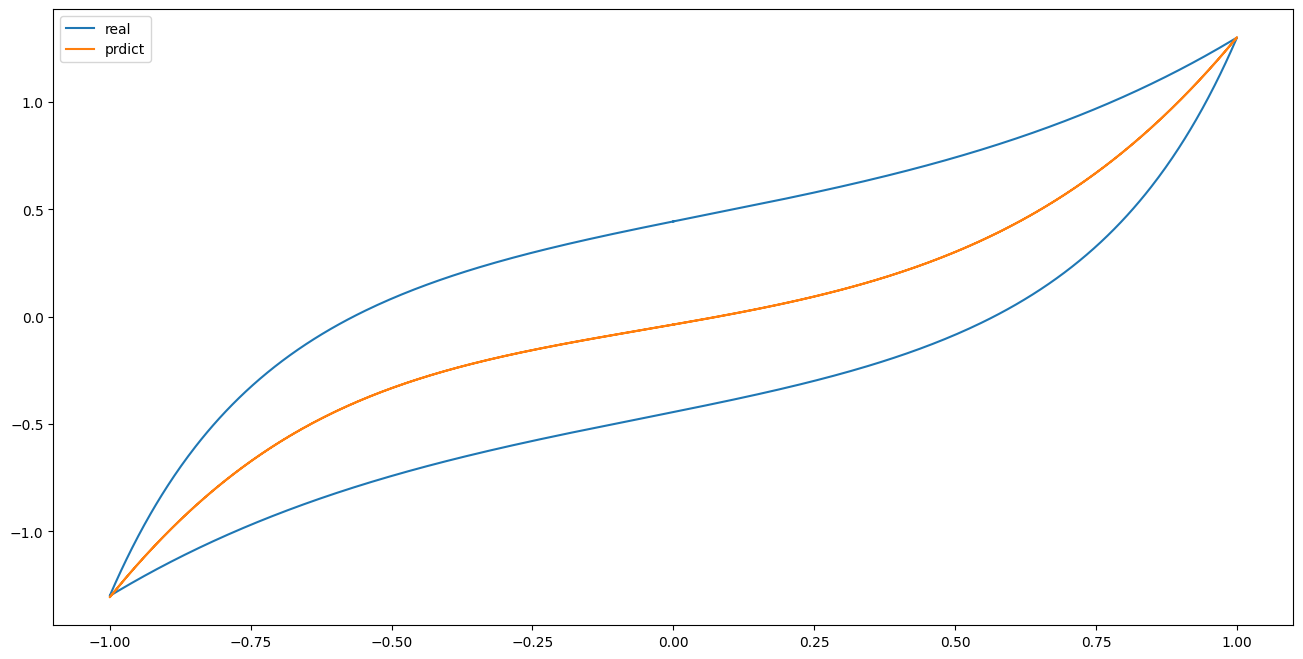

In [227]:
plt.figure(figsize=(16,8))
plt.plot(u[2000:], f[2000:], label = 'real')
plt.plot(u[2000:], pred, label = 'prdict')
plt.legend()
plt.show()

In [276]:
model_2 = Sequential()
model_2.add(tf.keras.layers.Dense(16, input_shape=(1, 1)))
model_2.add(tf.keras.layers.Dense(32, activation='relu'))
model_2.add(tf.keras.layers.Dense(64, activation='relu'))
model_2.add(tf.keras.layers.Dropout(0.4))
model_2.add(tf.keras.layers.Dense(128, activation='relu'))
model_2.add(tf.keras.layers.Dense(1))

model_2.compile(loss = 'mse', optimizer = 'adam')

In [277]:
model_2.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_152 (Dense)           (None, 1, 16)             32        
                                                                 
 dense_153 (Dense)           (None, 1, 32)             544       
                                                                 
 dense_154 (Dense)           (None, 1, 64)             2112      
                                                                 
 dropout_27 (Dropout)        (None, 1, 64)             0         
                                                                 
 dense_155 (Dense)           (None, 1, 128)            8320      
                                                                 
 dense_156 (Dense)           (None, 1, 1)              129       
                                                                 
Total params: 11,137
Trainable params: 11,137
Non-tra

In [278]:
dnn = model_2.fit(x_te, y_te, epochs=500, batch_size=16)

Epoch 1/500
63/63 [==============================] - 2s 2ms/step - loss: 0.6857
Epoch 2/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6857
Epoch 3/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6857
Epoch 4/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6857
Epoch 5/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6857
Epoch 6/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6857
Epoch 7/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6857
Epoch 8/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6857
Epoch 9/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6857
Epoch 10/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6857
Epoch 11/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6857
Epoch 12/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6857
Epoch 13/500
63/63 [=================

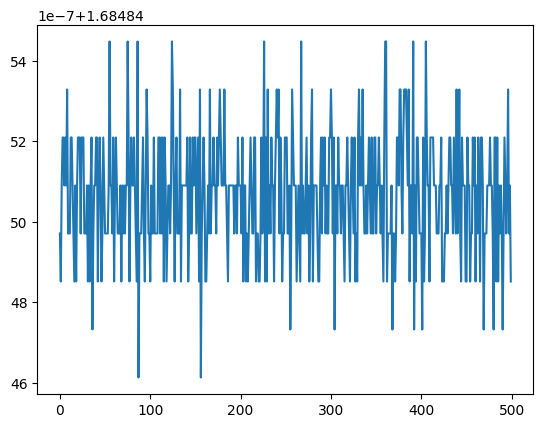

In [ ]:
plt.plot(dnn.history['loss'])

In [250]:
pred_2 = model_2.predict(x_te)

32/32 [==============================] - 0s 3ms/step


In [251]:
pred_2 = pred_2.reshape(-1,1)

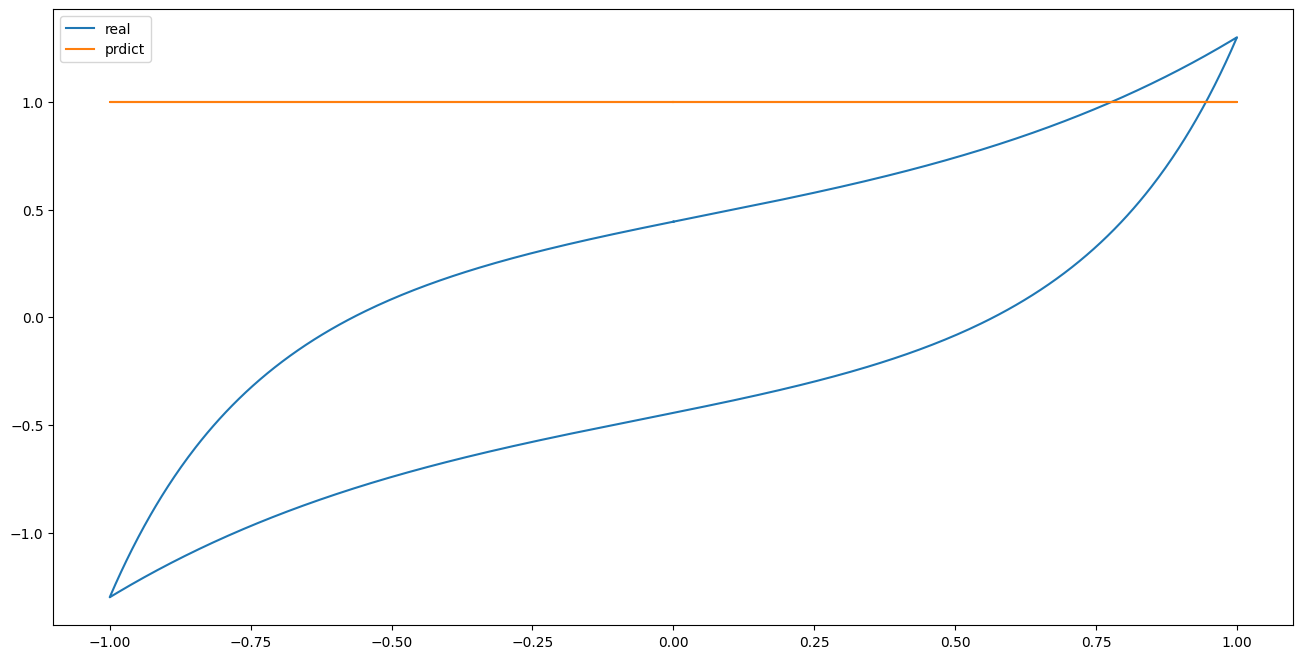

In [252]:
plt.figure(figsize=(16,8))
plt.plot(u[2000:], f[2000:], label = 'real')
plt.plot(u[2000:], pred_2, label = 'prdict')
plt.legend()
plt.show()